In [1]:
from glob import glob
import pandas as pd
import json
import os

def get_sequence_from_fasta_multiline(fa_dir, seq_tag):
    fasta_path = f'{fa_dir}/{seq_tag.split("_seq")[0]}.fa'
    header_keyword = f">{seq_tag}\n"
    with open(fasta_path) as f:
        lines = f.readlines()

    get_seq = False
    seq = ""
    for line in lines:
        if line.startswith(">"):
            get_seq = line.startswith(header_keyword)
            continue
        if get_seq:
            if line.strip():
                seq += line.strip()
            else:
                break
    return seq if seq else None

def get_fastrelax_data(tag, dir):
    seq_tag = tag
    seq_idx = int(tag.split('_')[-1])
    cycle_tag = tag.split('_seq')[0]
    json_file = f"{base_path}/stats/{cycle_tag}.json"
    with open(json_file, 'r') as f:
        data = json.load(f)
    score = data['all_relax_scores'][seq_idx]
    seq = get_sequence_from_fasta_multiline(f"{base_path}/seqs", seq_tag)
    fastrelax_item = {
        'cycle': int(cycle_tag.split('_')[-1]),
        'seq': seq,
        'mpnn': score['mpnn'],
        'ddg': score['metrics']['ddg'],
        'res_totalscore': score['metrics']['res_totalscore'],
        'cms': score['metrics']['cms']
    }
    return fastrelax_item

def natural_key(x):
    num = ''.join(filter(str.isdigit, x))
    return int(num) if num else x

dfs = []
projects = ['pht', 'cbz']
for project in projects:
    base_path = f'/home/hwjang/aipd/250729/6_fastrelax/{project}_fastrelax'
    pdb_files = glob(f'{base_path}/relaxed/*seq*.pdb')
    df = pd.DataFrame(pdb_files, columns=['path'])
    df['tag'] = df['path'].apply(lambda x: x.split('/')[-1].split('_relaxed')[0])
    df = df[['tag', 'path']]
    df = df.sort_values(by='tag', key=lambda col: col.map(natural_key)).reset_index(drop=True)
    
    fastrelax_dir = base_path
    df['fastrelax_data'] = df['tag'].apply(lambda x: get_fastrelax_data(x, fastrelax_dir))
    df_exp = pd.json_normalize(df['fastrelax_data'])
    df = pd.concat([df.drop(columns=['fastrelax_data']), df_exp], axis=1)
    df.columns = pd.MultiIndex.from_product([['fastrelax'], df.columns])
    df[('lmpnn', 'tag')] = df['fastrelax', 'tag'].apply(lambda x: x.split('_align')[0])
    df[('diffusion', 'batch')] = project
    dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True).reset_index(drop=True)
df.to_parquet('fastrelax.parquet')
df

fastrelax  \
                                                     tag   
0      result_722_packed_19_1_align_boltz_link.cif_cy...   
1      result_722_packed_19_1_align_boltz_link.cif_cy...   
2      result_722_packed_19_1_align_boltz_link.cif_cy...   
3      result_722_packed_19_1_align_boltz_link.cif_cy...   
4      result_722_packed_19_1_align_boltz_link.cif_cy...   
...                                                  ...   
19963  result_9892_packed_27_1_align_af3_link.cif_cyc...   
19964  result_9892_packed_27_1_align_af3_link.cif_cyc...   
19965  result_9892_packed_27_1_align_af3_link.cif_cyc...   
19966  result_9892_packed_27_1_align_af3_link.cif_cyc...   
19967  result_9892_packed_27_1_align_af3_link.cif_cyc...   

                                                                \
                                                    path cycle   
0      /home/hwjang/aipd/250729/6_fastrelax/pht_fastr...     1   
1      /home/hwjang/aipd/250729/6_fastrelax/pht_fastr...     1   
2      /home/hwjang/aipd/250729/6_fastrelax/pht_fastr...     1   
3      /home/hwjang/aipd/250729/6_fastrelax/pht_fastr...     1   
4      /home/hwjang/aipd/250729/6_fastrelax/pht_fastr...     1   
...                                                  ...   ...   
19963  /home/hwjang/aipd/250729/6_fastrelax/cbz_fastr...    32   
19964  /home/hwjang/aipd/250729/6_fastrelax/cbz_fastr...    32   
19965  /home/hwjang/aipd/250729/6_fastrelax/cbz_fastr...    32   
19966  /home/hwjang/aipd/250729/6_fastrelax/cbz_fastr...    32   
19967  /home/hwjang/aipd/250729/6_fastrelax/cbz_fastr...    32   

                                                                               \
                                                     seq      mpnn        ddg   
0      VLTEEEKAALAAERDAFLDFALAHYRETGELISLEVMERLRALSLR...  0.807230 -28.240777   
1      MLTAEQRAALAAQVDAFLAAWLAYYRETGELVSLEGMERLKALSLE...  0.821037 -27.407976   
2      MLTAEQKAALAERVDEFLDFALAYYRETGELVSLELCERLKELSLE...  0.866327 -32.074186   
3      VLTEEQRAELAAERQAFLDAWLADYRRSGRLVSLEGMERLKALSLK...  0.849570 -26.860311   
4      MLTAEERAALAARVDAFLDSWLADYRATGQLISLEGMERLRALSLE...  0.827402 -26.940067   
...                                                  ...       ...        ...   
19963  MRAVVLAADVDAGEGGLDKLPGIAAAVRALPGVSEVRILDAALVDG...  0.598263 -36.897580   
19964  MVESVLEAVVKAGEGGLDKLPGIAAAVAALPGVSRVEILDAELVDG...  0.606927 -35.799312   
19965  MREVVLEADVEAGEGGLDKLPGIAAAVAALPGVSEVRILDARLEDG...  0.569101 -35.870639   
19966  MKEVVLEAEVEAGEGGLDKLPEIAAAVAALPGVSRVEILDAKLENG...  0.574432 -36.220192   
19967  MRESVLEADVEAGEGGLDKLPEIAAAVAALPGVSRVEILDAERVDG...  0.558656 -36.398302   

                                                    lmpnn diffusion  
      res_totalscore         cms                      tag     batch  
0          -2.549467  213.810486   result_722_packed_19_1       pht  
1          -2.389793  210.431000   result_722_packed_19_1       pht  
2          -2.368577  209.142227   result_722_packed_19_1       pht  
3          -2.473202  203.762131   result_722_packed_19_1       pht  
4          -2.554110  205.573166   result_722_packed_19_1       pht  
...              ...         ...                      ...       ...  
19963      -3.124081  269.486176  result_9892_packed_27_1       cbz  
19964      -3.022231  270.748352  result_9892_packed_27_1       cbz  
19965      -3.074807  273.076599  result_9892_packed_27_1       cbz  
19966      -3.083702  272.316498  result_9892_packed_27_1       cbz  
19967      -2.989605  275.178711  result_9892_packed_27_1       cbz  

[19968 rows x 10 columns]

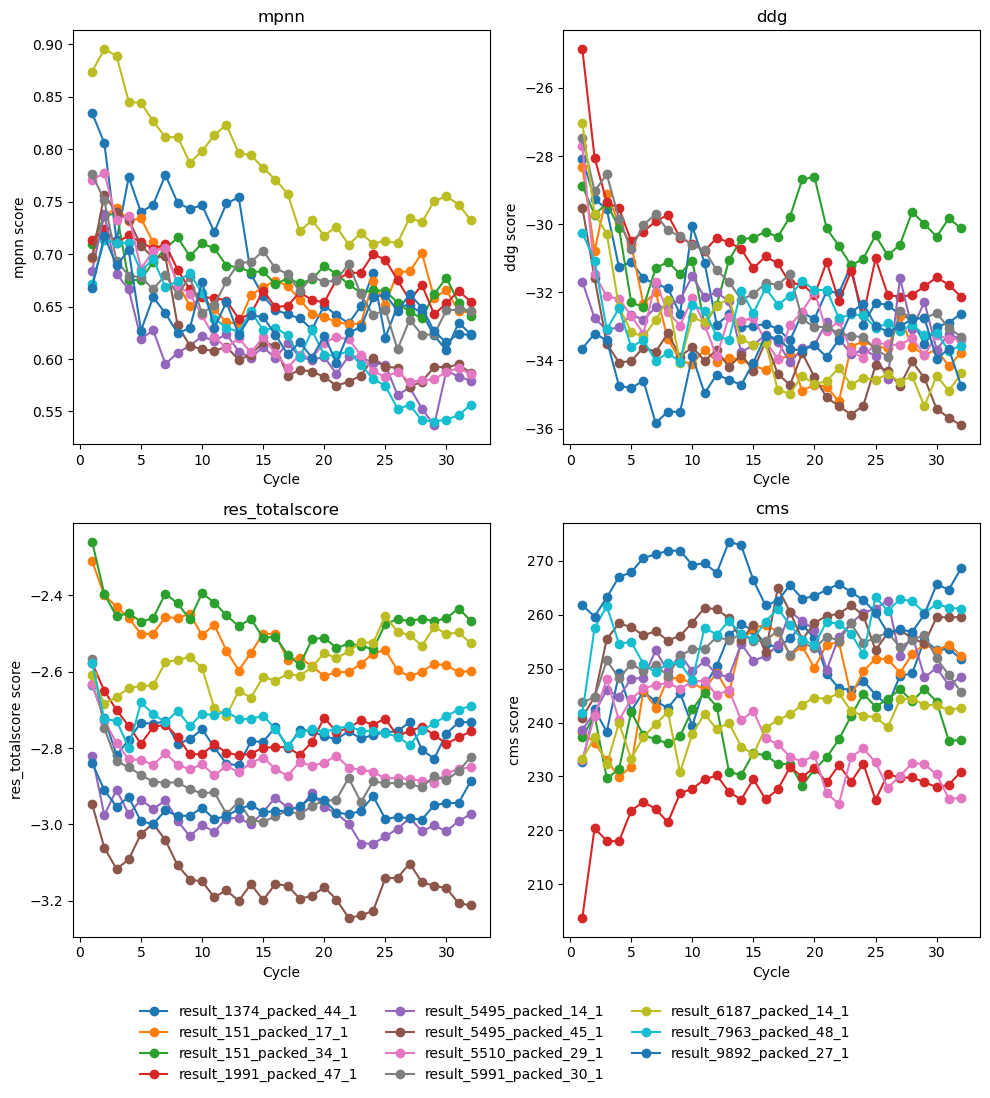

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

targets = ['mpnn', 'ddg', 'res_totalscore', 'cms']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lines = []
labels = []

plot_data = df.copy()
plot_data = plot_data[plot_data[('diffusion', 'batch')] == 'cbz']
for i, target in enumerate(targets):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    data = plot_data[[('lmpnn', 'tag'), ('fastrelax', 'cycle'), ('fastrelax', target)]].copy()
    data.columns = ['tag', 'cycle', target]
    grouped = data.groupby(['tag', 'cycle']).mean().reset_index()
    
    for tag, group in grouped.groupby('tag'):
        line, = ax.plot(group['cycle'], group[target], marker='o', label=f'{tag}')
        if i == 0:
            lines.append(line)
            labels.append(f'{tag}')
    ax.set_title(f'{target}')
    ax.set_xlabel('Cycle')
    ax.set_ylabel(f'{target} score')
    ax.legend().remove()

fig.legend(lines, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), frameon=False)
plt.tight_layout()
plt.savefig('fastrelax_scores.svg')
plt.show()